# On Support Vector Machines

Main information about document: support vector machines (abbreviated SVM) were checked on four datasets (called keywords, trimmed, removed, original) using k-fold cross-validation (5 splits). Note: Some different kernels were checked but only on the shorted dataset due to time and computer memory constraints.

Layout:
- Summary/what was the best model.
- Background and functions used in the check.
- Exploring C: comparing accuracies on LinearSVC for different values of C.
- Bagging results on the best linear model.
- Adaboosting results on the best linear model.
- (Unfinished**) Exploring Kernels: comparing accuracies for different kernels (with C = 1).

Indicators used to evaluate results:
- The main indicator was the model's overall accuracy.
- (Unused**) Additionally, each cuisine type has its own accuracy, precision, true positive rate, and false positive rate; each of which was compared across the different cuisine types using minimum, maximum, and average. 

Dataset Names (ordered from least features to most features):
- Keywords (this data set replaced the ingredients by a list of key words)
- Trimmed (this data set trimmed the original list of ingredients down to only those that appear at least 50 times)
- Removed (this data set had many brand names, adjectives and descriptors removed)
- Original (this is the uncleaned dataset)

** The unfinished section and unused indicators are things I would like to look at in the future but did not get time to do before the project deadline. Additionally, in the future, I would like to compare the number of n_estimators in the bagging and adaboost.

# Best Model

The best linear support vector machine had C = 0.1. 

Datasets (in order from best to worst performing) along with their LinearSVM accuracy results (averaged across the splits, rounded to two decimal places and C = 0.1): 
1. Removed - 78.59% accuracy
2. Original - 78.48% accuracy
3. Trimmed - 74.93% accuracy
4. Keywords - 70.71% accuracy

# Background Functions and loading

-- Packages and Data --

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
original = pd.read_csv("original_data.csv")
trimmed = pd.read_csv("train_trimmed.csv")
keywords = pd.read_csv("key_words_data.csv")
removed = pd.read_csv("remove_adj_data.csv")

In [3]:
from statistics import mean
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

kfold = StratifiedKFold(n_splits = 5,
                           shuffle = True,
                           random_state = 429)

In [4]:
SVM = LinearSVC(C = 0.1)

-- Functions --

In [5]:
## This is the confusion matrix for the dataframe
## This will be used in all functions in this document

## First input is the correct answers
    ## Specifically, our data is a subset of rows of a dataframe, one of whose columns is 'cuisine'.
    ## For example, if we are using the entire original data set (from github) to fit the model and run predictions,
        ## and name the dataframe "original", then we would use original['cuisine']
## Second input is the prediction

def our_matrix(data, prediction):
    return(confusion_matrix(data, prediction))

In [6]:
## percentage of times the correct answer was predicted

## First input: the correct answers
## Second input: the prediction

def total_accuracy(data, prediction):
    cm = our_matrix(data, prediction)
    denom = 0
    for i in range(20):
        denom = denom + cm[i][i]
    return(denom/len(data))

In [7]:
## For each cuisine type, we can find its true positive, false positive, false negative, and false positive values using these functions

## First input: correct answers
## Second input: cuisine type of interest
    ## Warning: name must be entered with quotes, e.g. 'italian'
## Third input: the model's predictions

## True Positive for "cuisine_type" based on the "prediction"
def tp_for_cuisine_type(data, cuisine_type, prediction):
    cm = our_matrix(data, prediction)
    i = data.value_counts().index.get_loc(cuisine_type)
    return(cm[i][i])

## False Positive for "cuisine_type" based on the "prediction"
def fp_for_cuisine_type(data, cuisine_type, prediction):
    cm = our_matrix(data, prediction)
    n = data.value_counts().index.get_loc(cuisine_type)
    summation = 0
    for i in range(20):
        if i != n:
            summation = summation + cm[n][i]
    return(summation)

## False Negative for "cuisine_type" based on the "prediction"
def fn_for_cuisine_type(data, cuisine_type, prediction):
    cm = our_matrix(data, prediction)
    n = data.value_counts().index.get_loc(cuisine_type)
    summation = 0
    for i in range(20):
        if i != n:
            summation = summation + cm[i][n]
    return(summation)

## True Negative for "cuisine_type" based on the "prediction"
def tn_for_cuisine_type(data, cuisine_type, prediction):
    cm = our_matrix(data, prediction)
    n = data.value_counts().index.get_loc(cuisine_type)
    summation = 0
    for i in range(20):
        for j in range(20):
            if (i != n) and (j != n):
                summation = summation + cm[i][j]
    return(summation)

Reminder for myself: What do the functions mean? Note: "cuisine_type" is a fixed value.
- Accuracy - probability of correct prediction (this is in the form "cuisine_type" or "not cuisine_type")
- Precision - probability that recipe with predicted "cuisine_type" is "cuisine_type"
- True positive rate - probability that recipe with "cuisine_type" is predicted to be "cuisine_type"
- True negative rate - probability that recipe with "not cuisine_type" is predicted to be "not cuisine_type"

In [8]:
## Performance Indicators for each cuisine type

## First input: correct answers
## Second input: cuisine type of interest
    ## Warning: name must be entered with quotes, e.g. 'italian'
## Third input: the model's predictions

def accuracy_for_cuisine_type(data, cuisine_type, prediction):
    denom = tp_for_cuisine_type(data, cuisine_type, prediction) + tn_for_cuisine_type(data, cuisine_type, prediction)
    numer = denom + fp_for_cuisine_type(data, cuisine_type, prediction) + fn_for_cuisine_type(data, cuisine_type, prediction)
    return(denom/numer)

def precision_for_cuisine_type(data, cuisine_type, prediction):
    denom = tp_for_cuisine_type(data, cuisine_type, prediction)
    numer = denom + fp_for_cuisine_type(data, cuisine_type, prediction)
    return(denom/numer)

def true_positive_rate_for_cuisine_type(data, cuisine_type, prediction):
    denom = tp_for_cuisine_type(data, cuisine_type, prediction)
    numer = denom + fn_for_cuisine_type(data, cuisine_type, prediction)
    return(denom/numer)

def true_negative_rate_for_cuisine_type(data, cuisine_type, prediction):
    denom = tn_for_cuisine_type(data, cuisine_type, prediction)
    numer = denom + fp_for_cuisine_type(data, cuisine_type, prediction)
    return(denom/numer)

In [9]:
## Overall Performance Indicators

## First input: dataframe column with the correct information, i.e. the correct answers
## Second input: a "_for_cuisine_type" indicator
## Third input: the predications from the model

def indicator_average(data, function, prediction):
    summation = 0
    for i in range(20):
        summation = summation + function(data, data.value_counts().index[i], prediction)
    return(summation/20)

## Fourth input: boolean
    ## True returns the minimum value, False returns the associated cuisine type
def min_of_indicator(data, function, prediction, boolean):
    values = []
    for i in range(20):
        values.append(function(data, data.value_counts().index[i], prediction))
    minimum = min(values)
    temp_location = values.index(minimum)
    location = data.value_counts().index[temp_location]
    if boolean == True:
        return(minimum)
    if boolean == False:
        return(location)

## Fourth input: boolean
    ## True returns the maximum value, False returns the associated cuisine type
def max_of_indicator(data, function, prediction, boolean):
    values = []
    for i in range(20):
        values.append(function(data, data.value_counts().index[i], prediction))
    maximum = max(values)
    temp_location = values.index(maximum)
    location = data.value_counts().index[temp_location]
    if boolean == True:
        return(maximum)
    if boolean == False:
        return(location)

In [10]:
## produces a dataframe containing some of the overall performance indicators for some of the indicators (accuracy, precision, true positive, true negative)

def reduced_overall_indicator_df(data, prediction):
    c1 = ['Average', 'Minimum Value', 'Maximum Value']
    c2 = [indicator_average(data, accuracy_for_cuisine_type, prediction), min_of_indicator(data, accuracy_for_cuisine_type, prediction, True), max_of_indicator(data, accuracy_for_cuisine_type, prediction, True)]
    c3 = [indicator_average(data, precision_for_cuisine_type, prediction), min_of_indicator(data, precision_for_cuisine_type, prediction, True), max_of_indicator(data, precision_for_cuisine_type, prediction, True)]
    c4 = [indicator_average(data, true_positive_rate_for_cuisine_type, prediction), min_of_indicator(data, true_positive_rate_for_cuisine_type, prediction, True), max_of_indicator(data, true_positive_rate_for_cuisine_type, prediction, True)]
    c5 = [indicator_average(data, true_negative_rate_for_cuisine_type, prediction), min_of_indicator(data, true_negative_rate_for_cuisine_type, prediction, True), max_of_indicator(data, true_negative_rate_for_cuisine_type, prediction, True)]
    data = {'Accuracy':c2, 'Precision':c3, 'True Positive Rate':c4, 'True Negative Rate':c5}
    df = pd.DataFrame(data, index = c1)
    return(df)

In [11]:
## an error function for a prediction

## First input: correct answers
## second input: model's prediction

def error_function(data, prediction):
    print("The total accuracy of the prediction is", total_accuracy(data, prediction))
    print()
    print("Each cuisine type has its own accuracy, precision, true positive rate, and false positive rate.")
    print("If we compare those four indicators across all of the cuisines we get the following table:")
    print()
    print(reduced_overall_indicator_df(data, prediction))

In [12]:
def cross_validation_with_model(dataframe, model):
    i = 0
    X = dataframe[dataframe.columns[2:]]
    y = dataframe['cuisine']
    for train_index, test_index in kfold.split(X, y):
        # getting the kfold training data and holdout data
        X_train = X.iloc[train_index]
        X_holdout = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_holdout = y.iloc[test_index]
        # fiting and predicting
        model.fit(X_train, y_train)
        pred = model.predict(X_holdout)
        # error
        print("----------------------------------------------------------")
        print()
        print("Split", i)
        error_function(y_holdout, pred)
        print()
        i = i + 1

In [13]:
def cross_validation_every_dataset(model):
    print("__________________________________________________________")
    print("Key Words Data Set")
    print("__________________________________________________________")
    cross_validation_with_model(keywords, model)
    print("__________________________________________________________")
    print("Trimmed Data Set")
    print("__________________________________________________________")
    cross_validation_with_model(trimmed, model)
    print("__________________________________________________________")
    print("Removed Adjectives Data Set")
    print("__________________________________________________________")
    cross_validation_with_model(removed, model)
    print("__________________________________________________________")
    print("Original Data Set")
    print("__________________________________________________________")
    cross_validation_with_model(original, model)

In [14]:
def average_total_accuracy_across_splits(dataframe, model):
    X = dataframe[dataframe.columns[2:]]
    y = dataframe['cuisine']
    accuracies = []
    for train_index, test_index in kfold.split(X, y):
        # getting the kfold training data and holdout data
        X_train = X.iloc[train_index]
        X_holdout = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_holdout = y.iloc[test_index]
        # fiting and predicting
        model.fit(X_train, y_train)
        pred = model.predict(X_holdout)
        totac = total_accuracy(y_holdout, pred)
        accuracies.append(totac)
    print("The averaged total accuracy across all splits is", mean(accuracies))
    print()

In [15]:
def average_accuracy_every_dataset(model):
    print("__________________________________________________________")
    print("Key Words Data Set")
    print("__________________________________________________________")
    average_total_accuracy_across_splits(keywords, model)
    print("__________________________________________________________")
    print("Trimmed Data Set")
    print("__________________________________________________________")
    average_total_accuracy_across_splits(trimmed, model)
    print("__________________________________________________________")
    print("Removed Adjectives Data Set")
    print("__________________________________________________________")
    average_total_accuracy_across_splits(removed, model)
    print("__________________________________________________________")
    print("Original Data Set")
    print("__________________________________________________________")
    average_total_accuracy_across_splits(original, model)

# Exploring C: comparing accuracy on LinearSVC for different values of C

Here we explore C by comparing the total accuracy of the model LinearSVC (across the 5 k-fold cross-validation splits) for different values of C on every dataset. A graph is given at the end.

Summary of section: C = 0.1 is the best.

In [15]:
for C in [10, 1, 0.1, 0.01]:
    print("----------------------------------------------------------")
    print("__________________________________________________________")
    print("C value is", C)
    print("__________________________________________________________")
    print("----------------------------------------------------------")
    svc_temp = LinearSVC(C=C)
    average_accuracy_every_dataset(svc_temp)

----------------------------------------------------------
__________________________________________________________
C value is 10
__________________________________________________________
----------------------------------------------------------
__________________________________________________________
Key Words Data Set
__________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

The averaged total accuracy across all splits is 0.7069694173300374

__________________________________________________________
Trimmed Data Set
__________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

The averaged total accuracy across all splits is 0.735983409949763

__________________________________________________________
Removed Adjectives Data Set
__________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

The averaged total accuracy across all splits is 0.7410621191271559

__________________________________________________________
Original Data Set
__________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

The averaged total accuracy across all splits is 0.7283402758823638

----------------------------------------------------------
__________________________________________________________
C value is 1
__________________________________________________________
----------------------------------------------------------
__________________________________________________________
Key Words Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.7081762560872092

__________________________________________________________
Trimmed Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.7456631413152338

__________________________________________________________
Removed Adjectives Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.7735707976426994

_________________________________________________________

In [16]:
## Note: while this could be automated, the numbers take a long time to find and I didn't realized I wanted to plot this until it was well into the computation so doing it manually was shorter at that point.

c_values = [10, 1, 0.1, 0.01]
c_for_keywords = [0.7069694173300374, 0.7081762560872092, 0.7071454357211414, 0.6900739086327148]
c_for_trimmed = [0.735983409949763, 0.7456631413152338, 0.7492835848871425, 0.73397208050628]
c_for_removed = [0.7410621191271559, 0.7735707976426994, 0.7859155195801376, 0.7576810058211839]
c_for_original = [0.7283402758823638, 0.7664807906303482, 0.7847589921116186, 0.7558707887765083]

In [17]:
from seaborn import swarmplot

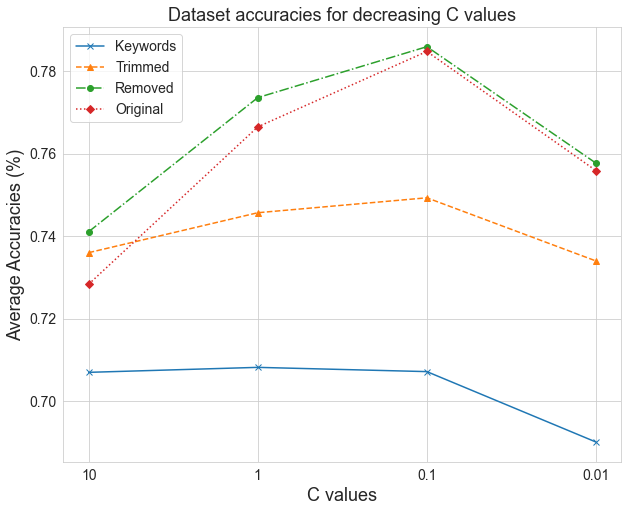

In [34]:
plt.figure(figsize=(10,8))

xi = list(range(len(c_values)))

plt.plot(xi, c_for_keywords, marker = 'x', linestyle = '-', label = "Keywords")
plt.plot(xi, c_for_trimmed, marker = '^', linestyle = '--', label = "Trimmed")
plt.plot(xi, c_for_removed, marker = 'o', linestyle = '-.', label = "Removed")
plt.plot(xi, c_for_original, marker = 'D', linestyle = ':', label = "Original")

plt.xlabel("C values", fontsize=18)
plt.ylabel("Average Accuracies (%)", fontsize=18)

plt.xticks(xi, c_values, fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.title('Dataset accuracies for decreasing C values', fontsize=18)

plt.show()

# Bagging on Best Linear Model

Summary of section: Accuracy was made worse by bagging. Note: compared accuracies below to accuracies in "Exploring C". Will not explore higher value for n_estimators due to how long 100 estimators took.

In [19]:
from sklearn.ensemble import BaggingClassifier

In [20]:
bag = BaggingClassifier(base_estimator = SVM,
                           bootstrap = True,
                           n_estimators = 100, # if time, change this number for futher tests
                           max_samples = 3000)

Bagging results on all datasets

In [21]:
average_accuracy_every_dataset(bag)

__________________________________________________________
Key Words Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.6883643015219346

__________________________________________________________
Trimmed Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.7233871853035533

__________________________________________________________
Removed Adjectives Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.7409867106699475

__________________________________________________________
Original Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.7360336011260221



# AdaBoost on Best Linear Model

Summary of section: Accuracy was made worse by boosting. Note: compared accuracies below to accuracies in "Exploring C". Will not explore higher value for n_estimators due to how long 50 estimators.

In [22]:
from sklearn.ensemble import AdaBoostClassifier

In [23]:
ada_clf = AdaBoostClassifier(SVM,
                                n_estimators=10, # if time, change this number for futher tests
                                algorithm = 'SAMME',
                                random_state=123)

Adaboost results on every dataset

In [24]:
average_accuracy_every_dataset(ada_clf)

__________________________________________________________
Key Words Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.500879785352831

__________________________________________________________
Trimmed Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.5215971344975913

__________________________________________________________
Removed Adjectives Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.5349732141460158

__________________________________________________________
Original Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.5244381529432199



In [25]:
ada_50 = AdaBoostClassifier(SVM,
                                n_estimators=50,
                                algorithm = 'SAMME',
                                random_state=123)

In [26]:
average_accuracy_every_dataset(ada_50)

__________________________________________________________
Key Words Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.5308244593717458

__________________________________________________________
Trimmed Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.5824154507525753

__________________________________________________________
Removed Adjectives Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.6018756119212815

__________________________________________________________
Original Data Set
__________________________________________________________
The averaged total accuracy across all splits is 0.5994871611704446



# (Unfinished) Exploring Kernels: comparing accuracy for different kernels.

Here we explore the kernels by comparing the total accuracy of the models for the smallest dataset Keywords. Note: C = 1 is used for all kernels.

-- rbf kernel --

In [27]:
svc_rbf = SVC(kernel='rbf', C=1)

In [28]:
average_total_accuracy_across_splits(keywords, svc_rbf)

The averaged total accuracy across all splits is 0.7372152384065068



In [33]:
average_total_accuracy_across_splits(trimmed, svc_rbf)

KeyboardInterrupt: 

-- sigmoid kernel --

In [29]:
svc_sig = SVC(kernel='sigmoid', C=1)

In [30]:
average_total_accuracy_across_splits(keywords, svc_sig)

The averaged total accuracy across all splits is 0.606426344946674



-- polynomial kernel -- 

To do: look at a few different degrees for the polynomial.

In [ ]:
for degree in [2, 3, 4]:
    print("----------------------------------------------------------")
    print("__________________________________________________________")
    print("Degree is", degree)
    print("__________________________________________________________")
    print("----------------------------------------------------------")
    svc_poly = SVC(kernel='poly', degree=degree, C=1)
    average_total_accuracy_across_splits(keywords, svc_poly)